## Evaluate the Outcomes of Simulatinos
Make sure that the simulations ran as expected

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

## Load Simulation Results
Get the results from simulation tasks

In [2]:
def load_tasks(run_path: str) -> pd.DataFrame:
    task_info = []
    with open(f'{run_path}/simulation-results.json') as fp:
        for line in fp:
            try:
                record = json.loads(line)
            except json.JSONDecodeError: 
                continue
            for f in ['task_id', 'failure_info', 'worker_info', 'serialization_method',
                     'additional_timing']:
                record.pop(f)
            record['recipes'] = tuple(f'{x["name"]}/{x["level"]}' for x in record['task_info']['recipes'])
            record['molecule'] = record['task_info']['key']
            task_info.append(record)
    task_info = pd.DataFrame(task_info)
    print(f'Loaded {len(task_info)} task records')
    
    # Group simulation tasks by recipe and molecule
    grouped_tasks = task_info.groupby(['molecule', 'recipes']).agg({'time_running': 'sum', 'time_result_received': 'min'}).sort_values('time_result_received')
    grouped_tasks['walltime'] = grouped_tasks['time_result_received'] - grouped_tasks['time_result_received'].min()
    grouped_tasks['compute_time'] = grouped_tasks['time_running'].cumsum()
    grouped_tasks.reset_index(inplace=True)
    print(f'Consolidated to {len(grouped_tasks)} computations')
    
    # Store the results
    db = {}
    with open(f'{run_path}/database.json') as fp:
        for line in fp:
            record = json.loads(line)
            db[record['key']] = record
            
    # Get the results from each computation
    all_recipes = sum(map(list, set(grouped_tasks['recipes'])), [])
    grouped_tasks['smiles'] = grouped_tasks.apply(lambda x: db.get(x['molecule'], {}).get('identifier', {}).get('smiles'), axis=1)
    for recipe in all_recipes:
        prop, levl = recipe.split("/")
        grouped_tasks[recipe] = grouped_tasks.apply(lambda x: db.get(x['molecule'], {}).get('properties', {}).get(prop, {}).get(levl) if recipe in x['recipes'] else None, axis=1)
    return grouped_tasks

In [3]:
multfi_tasks = load_tasks('run')
multfi_tasks.tail()

Loaded 420 task records
Consolidated to 214 computations


,molecule,recipes,time_running,time_result_received,walltime,compute_time,smiles,oxidation_potential/mopac_pm7-acn-vertical,oxidation_potential/mopac_pm7-acn-adiabatic,solvation_energy/mopac_pm7-acn,oxidation_potential/mopac_pm7-vertical
209,LNRLUQIHOWKFMD-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-vertical,)",13.649488,1.701977e+09,899.012115,2636.626223,COCOC(COC)C(c1ccc(C(C)OC)cc1)([N+](=O)[O-])[N+...,NaN,NaN,NaN,9.31
210,UYGWGMJKFNTSDV-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",50.808988,1.701977e+09,917.916562,2687.435211,CCCOC(OCOC)C(OC)(c1ccc(C=O)cc1)C(C)OC,NaN,6.895047,-13.6454,NaN
211,IAHXKVHHVFSEHB-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-vertical,)",0.078529,1.701977e+09,931.283436,2687.513740,COCOC([N+](=O)[O-])C(C=O)(c1ccc(C=O)cc1)[N+](=...,NaN,NaN,NaN,NaN
212,ZLULEADOZLYAPX-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-vertical,)",11.283795,1.701977e+09,942.181175,2698.797535,COCC(OC)C(OC)(c1ccc(C(C)C)cc1)[N+](=O)[O-],NaN,NaN,NaN,NaN
213,YRMREGVHIJKVHN-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",14.680816,1.701977e+09,945.877630,2713.478351,CC(C)OC(OC(C)C)C(C=O)(c1ccc(C=O)cc1)[N+](=O)[O-],NaN,NaN,-13.1968,NaN


In [4]:
singfi_tasks = load_tasks('run-single')
singfi_tasks.head()

Loaded 198 task records
Consolidated to 57 computations


,molecule,recipes,time_running,time_result_received,walltime,compute_time,smiles,oxidation_potential/mopac_pm7-acn-adiabatic,solvation_energy/mopac_pm7-acn
0,IZNDNYLIQWXJIW-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",87.987414,1.701977e+09,0.000000,87.987414,COCC(OC)C(COC)(c1ccc(C(C)C)cc1)C(C)OC,NaN,NaN
1,IXCMFNWOAWAVRN-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",80.393023,1.701977e+09,1.004237,168.380438,CCCOC(C(C)OC)C(COC)(COC)c1ccc(COC)cc1,NaN,NaN
2,VVZVMAFKYZBGMN-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",134.945532,1.701977e+09,13.152279,303.325970,CCCOC(OCCC)C(Br)(OC(C)C)c1ccc(CCCOCC)cc1,NaN,NaN
3,YDNFHLJFKVWJOG-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",32.268866,1.701977e+09,22.170676,335.594836,CCCOC(CCC)C(Br)(OCCC)c1ccc(OC(C)C)cc1,6.468634,-8.85000
4,DYJPYPBAVREUCO-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",30.155898,1.701977e+09,50.316627,365.750734,CCOC(Br)(c1ccc(C)cc1)C(C=O)OC,6.953480,-9.47999


In [5]:
random_tasks = load_tasks('run-single-random')
random_tasks.head()

Loaded 233 task records
Consolidated to 66 computations


,molecule,recipes,time_running,time_result_received,walltime,compute_time,smiles,oxidation_potential/mopac_pm7-acn-adiabatic,solvation_energy/mopac_pm7-acn
0,ZRDYPOIRGDRMNI-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",68.143295,1.701980e+09,0.000000,68.143295,CCCC(OCCOC)C(CC)(c1ccc(CCCOCC)cc1)C(C)OC,6.379811,-10.95075
1,IXMBRMFEJUMUHY-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",105.454581,1.701980e+09,3.307640,173.597876,COCC(c1ccc(Br)cc1)(C(Oc1ccccc1)OC(C)C)[N+](=O)...,6.577497,-9.37320
2,XFUWYMUPVITGRN-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",44.617212,1.701980e+09,8.963698,218.215088,CCCC(Oc1ccccc1)C(CCC)(OC(C)C)c1ccc(COC)cc1,6.349893,-7.62629
3,CPUIUFQZBAFREG-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",58.478781,1.701980e+09,20.832516,276.693869,COCCOC(COC)C(CCOC)(COC)c1ccc(C)cc1,6.610294,-12.39686
4,PQRSUOQUPPEJJW-UHFFFAOYSA-N,"(oxidation_potential/mopac_pm7-acn-adiabatic, ...",32.743131,1.701980e+09,44.444276,309.437001,CCOC(OC)C(CC)(c1ccc(C(C)C)cc1)N(C)C,5.204699,-7.41305


## Plot Task Mix by Time
See how many tasks of each time we have run by each timestamp

In [6]:
all_recipes = set(multfi_tasks['recipes'])

Text(0.5, 0, 'Walltime (hr)')

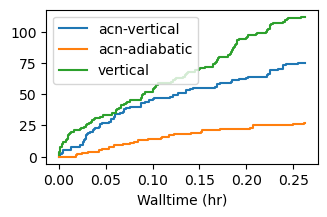

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for recipe in all_recipes:
    count = (multfi_tasks['recipes'] == recipe).cumsum()
    ax.step(multfi_tasks['walltime'] / 3600, count, label=recipe[0][30:])
    
    ax.legend()

ax.set_xlabel('Walltime (hr)')

We have a roughly 50% decrease at each step (vertical->acn-vertical->acn-adiabatic)

## Plot IP by Walltime
See how well we're doing for finding a maximum redox potential

In [8]:
plot_list = list(zip(['red', 'blue', 'slategray'], ['^', 'v', 'x'], ['Single', 'Multi', 'Random'], [singfi_tasks, multfi_tasks, random_tasks]))

/tmp/ipykernel_525765/1307738037.py:6: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(tasks['compute_time'] / 3600, tasks[result], s=10,


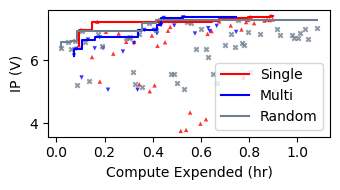

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

result = 'oxidation_potential/mopac_pm7-acn-adiabatic'
for color, marker, label, tasks in plot_list:
    tasks = tasks[~tasks[result].isnull()]
    ax.scatter(tasks['compute_time'] / 3600, tasks[result], s=10, 
               color=color, alpha=0.8, edgecolor='none', marker=marker)
    cummax = tasks[result].cummax()
    ax.step(tasks['compute_time'] / 3600, cummax, '-', color=color, label=label)

ax.set_xlabel('Compute Expended (hr)')
ax.set_ylabel('IP (V)')

ax.legend()

fig.tight_layout()

Plot the distribution of IPs after 2 hours of compute

Single - Mean: 6.14 V - Count: 30
Multi - Mean: 6.62 V - Count: 25
Random - Mean: 6.28 V - Count: 35


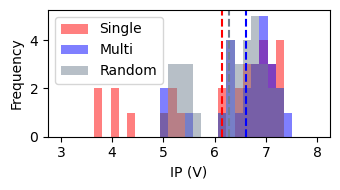

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

bins = np.linspace(3, 8, 32)
means = []

result = 'oxidation_potential/mopac_pm7-acn-adiabatic'
for color, marker, label, tasks in plot_list:
    subset = tasks.query('compute_time <= 2700')
    subset = subset[~subset[result].isnull()]
    ax.hist(subset[result], bins=bins, color=color, label=label, alpha=0.5)
    print(f'{label} - Mean: {subset[result].mean():.2f} V - Count: {len(subset)}')
    
    means.append((color, subset[result].mean()))

ax.set_ylim(ax.get_ylim())
for color, mean in means:
    ax.plot([mean] * 2, ax.get_ylim(), '--', color=color)

ax.set_xlabel('IP (V)')
ax.set_ylabel('Frequency')

ax.legend()

fig.tight_layout()

The average IP of the molecules run at the highest level is higher for the multi-fidelity case, though there are are fewer overall

## Plot Solvation and Redox
See if the multi-objective optimization is working

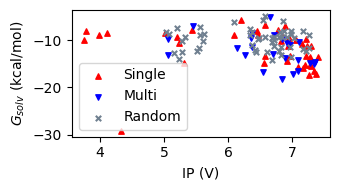

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))


for color, marker, label, tasks in plot_list:
    subset = tasks.query('compute_time <= 2700')
    ax.scatter(tasks['oxidation_potential/mopac_pm7-acn-adiabatic'], tasks['solvation_energy/mopac_pm7-acn'], color=color, label=label, s=15, marker=marker)
    
ax.legend()

ax.set_xlabel('IP (V)')
ax.set_ylabel('$G_{solv}$ (kcal/mol)')

fig.tight_layout()

Multi-fidelity and single push towards the target region (bottom right) much better.